# Lineare Regression mit zwei unabhängigen Variablen

- `matplotlib.pyplot`: Die grundlegende Bibliothek für die Erstellung von Plots, Achsen und Anpassungen.

- `seaborn`: Baut auf Matplotlib auf und wird für ansprechendere statistische Visualisierungen und das Plot-Design verwendet.

- `matplotlib.lines.Line2D`: Speziell für die Erstellung benutzerdefinierter Legendeneinträge, z.B. für 3D-Oberflächen.

## 0. Setup

In [64]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from pathlib import Path # Import für professionelles Pfad-Management

In [65]:
# Konfiguration

# Pfad
DATA_FOLDER = "Data"
FILE_NAME = "Eisverkauf_Beobachtungsdaten_Matrix.xlsx"
DATA_FILE = Path(DATA_FOLDER) / FILE_NAME

# Parameter
RANDOM_STATE = 42 # Für reproduzierbare Ergebnisse

# Matplotlib-Plots direkt im Notebook anzeigen und Theme setzen
%matplotlib inline
sns.set_theme(style="whitegrid")

## 1. Daten Laden 

In [66]:
try:
    df = pd.read_excel(DATA_FILE)
    print(f"Daten erfolgreich geladen: \n{len(df)} Datensätze gefunden.")
except FileNotFoundError:
    print(f"FEHLER: Die Datei '{DATA_FILE}' wurde nicht gefunden. Bitte überprüfen Sie den Pfad.")
    df = None

Daten erfolgreich geladen: 
9 Datensätze gefunden.


## 2 Datenstruktur umformen

In [67]:
# Die ID-Variable ist die erste Spalte, 
id_vars = ['Temperatur\nRegen']

# Temperaturwerte aud er ersten Zeile auslesen 
value_vars = [] 
for col in df.columns:
    if isinstance(col, (int, float)):
        value_vars.append(col) # Wenn ja, füge ihn zur Liste hinzu
print(f"Temp Werte: {value_vars}")

# Daten umformen (zwei neue Spalten Erstellen)
# 'Temperatur' wird der neue Spaltenname für die ursprünglichen numerischen Spaltennamen (z.B. 14, 18)
# 'Eisabsatz' wird der neue Spaltenname für die Werte in diesen Spalten.
df_transformed = pd.melt(df, id_vars=id_vars, value_vars=value_vars, var_name='Temperatur', value_name='Eisabsatz')

Temp Werte: [14, 18, 22, 25, 26, 28, 30]


In [68]:
# Spalte für bessere Lesbarkeit umbenennen
df_transformed = df_transformed.rename(columns={'Temperatur\nRegen': 'Regen'})

# Datentypen anpassen
df_transformed['Temperatur'] = df_transformed['Temperatur'].astype(int)
df_transformed = df_transformed.dropna(subset=['Eisabsatz'])               # Entfernt  alle unvollständigen Datenpunkte 
df_transformed['Eisabsatz'] = df_transformed['Eisabsatz'].astype(float)

print(f"Transformierter DataFrame (erste 5 Zeilen): \n{df_transformed.head()}")

Transformierter DataFrame (erste 5 Zeilen): 
   Regen  Temperatur  Eisabsatz
0      0          14        1.0
2      2          14        0.5
4      5          14        0.0
8     10          14        0.0
9      0          18       16.0


### 2.1 Modell trainieren und visualisieren 

In [69]:
# Features (X) und Zielvariable (y) definieren
features = ['Temperatur', 'Regen']
X = df_transformed[features]
y = df_transformed['Eisabsatz']

print(f"\nGesamter Datensatz wird für das Training verwendet: \n{len(X)} Datensätze.")


Gesamter Datensatz wird für das Training verwendet: 
29 Datensätze.


In [70]:
# Trainieren
model = LinearRegression()
model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [71]:
# Vorhersagen auf dem gesamten Datensatz machen, um die Modellgüte zu bewerten
y_pred = model.predict(X)

a = model.intercept_
b = model.coef_[0]
c = model.coef_[1]

# Die gelernten Koeffizienten und den Achsenabschnitt ausgeben y(x_1=t,x_2=r) = a + b*t + c*r
print("\nModellergebnisse (trainiert auf allen Daten):")
print(f"Achsenabschnitt (Intercept): {a:.2f}")
print(f"Koeffizient für 'Temperatur': {b:.2f}")
print(f"Koeffizient für 'Regen': {c:.2f}")


Modellergebnisse (trainiert auf allen Daten):
Achsenabschnitt (Intercept): -15.24
Koeffizient für 'Temperatur': 1.66
Koeffizient für 'Regen': -1.78


### 2.2 Metriken 

In [ ]:
# Metriken zur Güteberechnung (auf dem gesamten Datensatz)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print("\nModellgüte (bewertet auf allen Daten):")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-Quadrat (R²): {r2:.4f}")

# Adjustiertes R-Quadrat berechnen
n = len(y)       # Anzahl der Beobachtungen
p = X.shape[1]   # Anzahl der Prädiktoren
r2_adj = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
print(f"Adjustiertes R-Quadrat (R²_adj): {r2_adj:.4f}")



Modellgüte (bewertet auf allen Daten):
Mean Absolute Error (MAE): 3.26
Mean Squared Error (MSE): 17.81
R-Quadrat (R²): 0.8759
Adjustiertes R-Quadrat (R²_adj): 0.8663


### 2.3 Visualisierung

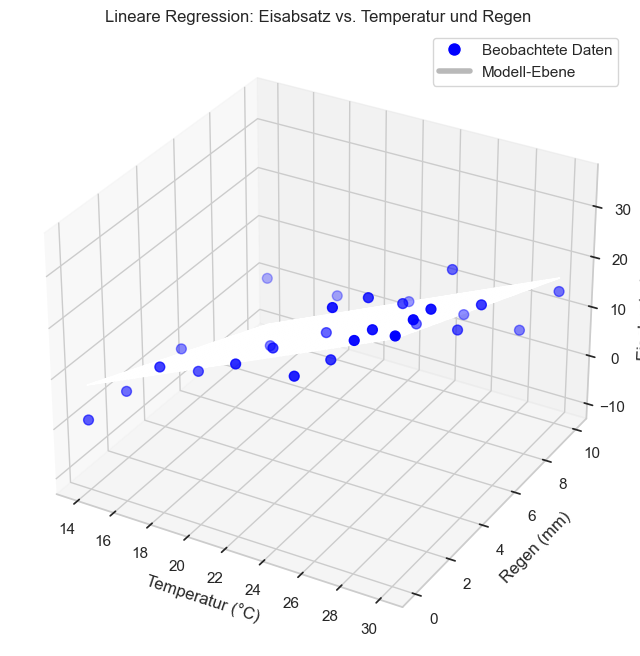

In [73]:
# Erstellen eines Gitters für die Regressionsebene
x_surf, y_surf = np.meshgrid(
    np.linspace(df_transformed['Temperatur'].min(), df_transformed['Temperatur'].max(), 100),
    np.linspace(df_transformed['Regen'].min(), df_transformed['Regen'].max(), 100)
)

# Die Regressionsgleichung lautet: y = a + b*Temperatur + c*Regen
# Wir berechnen den z-Wert (Eisabsatz) für jeden Punkt im Gitter explizit
z_surf = a + b * x_surf + c * y_surf

# 3D-Plot erstellen
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Datenpunkte plotten (alle Daten aus dem transformierten DataFrame)
ax.scatter(df_transformed['Temperatur'], df_transformed['Regen'], df_transformed['Eisabsatz'], c='blue', marker='o', label='Beobachtete Daten', s=50)

# Regressionsebene plotten
ax.plot_surface(x_surf, y_surf, z_surf, alpha=0.2, color='k', label='Modell-Ebene')

# Achsenbeschriftungen und Titel
ax.set_xlabel('Temperatur (°C)')
ax.set_ylabel('Regen (mm)')
ax.set_zlabel('Eisabsatz (x1000 €)')
ax.set_title('Lineare Regression: Eisabsatz vs. Temperatur und Regen')

# Legende anzeigen (ein kleiner Trick ist nötig, um das Oberflächen-Label anzuzeigen)
from matplotlib.lines import Line2D
custom_legend = [
    Line2D([0], [0], marker='o', color='w', label='Beobachtete Daten', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], color='k', lw=4, label='Modell-Ebene', alpha=0.3)
]
ax.legend(handles=custom_legend)

# Plot anzeigen
plt.show()

## 3. Kennzahlen 

In [74]:
# Vorhersagen auf den Testdaten machen
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R-Quadrat (R²): {r2:.4f}")

n = len(y_test)       # Zeilen
p = X_test.shape[1]         # Spalten
r2_adj = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
print(f"Adjustiertes R-Quadrat (R²_adj): {r2_adj:.4f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mittlerer Absoluter Fehler (MAE): {mae:.2f}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mittlerer Quadratischer Fehler (MSE): {mse:.2f}")

rmse = np.sqrt(mse)
print(f"Wurzel des Mittleren Quadratischen Fehlers (RMSE): {rmse:.2f}")

R-Quadrat (R²): 0.5402
Adjustiertes R-Quadrat (R²_adj): 0.2336
Mittlerer Absoluter Fehler (MAE): 2.76
Mittlerer Quadratischer Fehler (MSE): 14.36
Wurzel des Mittleren Quadratischen Fehlers (RMSE): 3.79


## 4. Ergebnisse Visualisieren (3D)

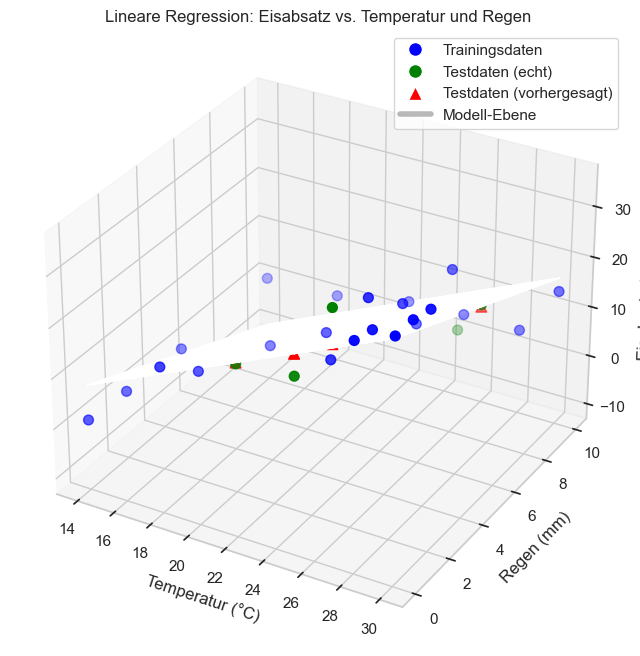

In [75]:
# Erstellen eines Gitters für die Regressionsebene
x_surf, y_surf = np.meshgrid(
    np.linspace(df_transformed['Temperatur'].min(), df_transformed['Temperatur'].max(), 100),
    np.linspace(df_transformed['Regen'].min(), df_transformed['Regen'].max(), 100)
)

# Die Regressionsgleichung lautet: y = a + b*Temperatur + c*Regen
# Wir berechnen den z-Wert (Eisabsatz) für jeden Punkt im Gitter explizit
z_surf = a + b * x_surf + c * y_surf

# 3D-Plot erstellen
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 1. Trainingsdatenpunkte plotten (Blau)
ax.scatter(X_train['Temperatur'], X_train['Regen'], y_train, c='blue', marker='o', label='Trainingsdaten', s=50)

# 2. Testdatenpunkte (echte Werte) plotten (Grün)
ax.scatter(X_test['Temperatur'], X_test['Regen'], y_test, c='green', marker='o', label='Testdaten (echt)', s=50)

# 3. Vorhergesagte Werte für die Testdaten plotten (Rot)
ax.scatter(X_test['Temperatur'], X_test['Regen'], y_pred, c='red', marker='^', label='Testdaten (vorhergesagt)', s=60)

# 4. Regressionsebene plotten
ax.plot_surface(x_surf, y_surf, z_surf, alpha=0.2, color='k', label='Modell-Ebene')

# Achsenbeschriftungen und Titel
ax.set_xlabel('Temperatur (°C)')
ax.set_ylabel('Regen (mm)')
ax.set_zlabel('Eisabsatz (x1000 €)')
ax.set_title('Lineare Regression: Eisabsatz vs. Temperatur und Regen')

# Legende anzeigen (ein kleiner Trick ist nötig, um das Oberflächen-Label anzuzeigen)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Trainingsdaten', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Testdaten (echt)', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='^', color='w', label='Testdaten (vorhergesagt)', markerfacecolor='red', markersize=10),
    Line2D([0], [0], color='k', lw=4, label='Modell-Ebene', alpha=0.3)
]
ax.legend(handles=legend_elements)

# Plot anzeigen
plt.show()

## 5. 2D Darstellung

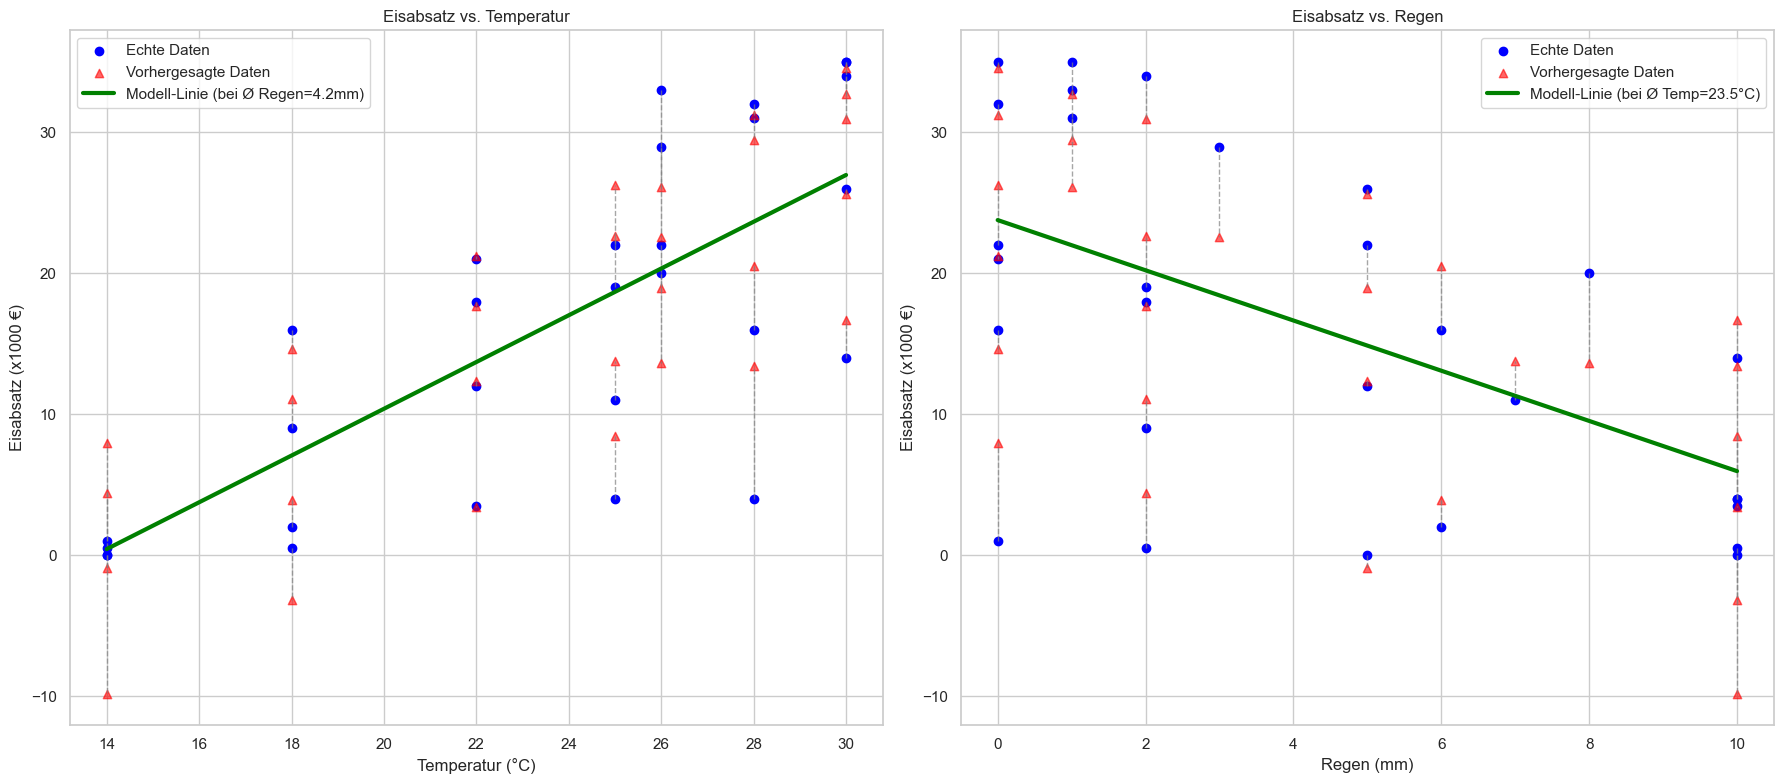

In [76]:

# Erstelle eine Figur mit zwei Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Wir brauchen die Vorhersagen für den gesamten Datensatz
y_pred_all = model.predict(X)

# --- Plot 1: Eisabsatz vs. Temperatur ---

# 1. Echte Datenpunkte (Blau)
ax1.scatter(X['Temperatur'], y, c='blue', label='Echte Daten')

# 2. Vorhergesagte Datenpunkte (Rot)
ax1.scatter(X['Temperatur'], y_pred_all, c='red', marker='^', alpha=0.6, label='Vorhergesagte Daten')

# 3. Fehlerlinien (Grau)
for i in range(len(X)):
   ax1.plot([X['Temperatur'].iloc[i], X['Temperatur'].iloc[i]],
            [y.iloc[i], y_pred_all[i]],
            color='gray', linestyle='--', linewidth=1, alpha=0.7)

# 4. Regressionslinie des Modells hinzufügen (Grün) mit expliziten Koeffizienten
#    Wir halten 'Regen' auf seinem Durchschnittswert konstant, um die Linie zu zeichnen.
temp_range = np.linspace(X['Temperatur'].min(), X['Temperatur'].max(), 100)
regen_mean = X['Regen'].mean()
# Die Modellgleichung für die Linie: y = a + b*Temperatur + c*durchschnittlicher_Regen
y_pred_line_temp = a + b * temp_range + c * regen_mean
ax1.plot(temp_range, y_pred_line_temp, color='green', linewidth=3, linestyle='-', label=f'Modell-Linie (bei Ø Regen={regen_mean:.1f}mm)')

ax1.set_xlabel('Temperatur (°C)')
ax1.set_ylabel('Eisabsatz (x1000 €)')
ax1.set_title('Eisabsatz vs. Temperatur')
ax1.legend()
ax1.grid(True)

# --- Plot 2: Eisabsatz vs. Regen ---

# 1. Echte Datenpunkte (Blau)
ax2.scatter(X['Regen'], y, c='blue', label='Echte Daten')

# 2. Vorhergesagte Datenpunkte (Rot)
ax2.scatter(X['Regen'], y_pred_all, c='red', marker='^', alpha=0.6, label='Vorhergesagte Daten')

# 3. Fehlerlinien (Grau)
for i in range(len(X)):
   ax2.plot([X['Regen'].iloc[i], X['Regen'].iloc[i]],
            [y.iloc[i], y_pred_all[i]],
            color='gray', linestyle='--', linewidth=1, alpha=0.7)

# 4. Regressionslinie des Modells hinzufügen (Grün) mit expliziten Koeffizienten
#    Wir halten 'Temperatur' auf ihrem Durchschnittswert konstant, um die Linie zu zeichnen.
regen_range = np.linspace(X['Regen'].min(), X['Regen'].max(), 100)
temp_mean = X['Temperatur'].mean()
# Die Modellgleichung für die Linie: y = a + b*durchschnittliche_Temperatur + c*Regen
y_pred_line_regen = a + b * temp_mean + c * regen_range
ax2.plot(regen_range, y_pred_line_regen, color='green', linewidth=3, linestyle='-', label=f'Modell-Linie (bei Ø Temp={temp_mean:.1f}°C)')

ax2.set_xlabel('Regen (mm)')
ax2.set_ylabel('Eisabsatz (x1000 €)')
ax2.set_title('Eisabsatz vs. Regen')
ax2.legend()
ax2.grid(True)


# Zeige die Plots an
plt.tight_layout()
plt.show()

## 6. Prognose für neue, unbekannte Daten 

In [77]:

# Schritt 1: Eine umfangreiche Liste von neuen, fiktiven Wetterdaten erstellen.
# Diese repräsentieren die Wertepaare, für die wir eine Prognose wollen.

print("Schritt 1: Erstelle neue Wetterdaten für die Prognose...")
anzahl_neuer_werte = 200
neue_wetterdaten = {
    'Temperatur': np.random.uniform(5, 40, anzahl_neuer_werte), # Temperaturen zwischen 5°C und 40°C
    'Regen': np.random.uniform(0, 30, anzahl_neuer_werte)      # Regen zwischen 0mm und 30mm
}
df_prognose_input = pd.DataFrame(neue_wetterdaten)

# Runden der Werte für eine sauberere Darstellung
df_prognose_input = df_prognose_input.round(1)

# Schritt 2: Speichern dieser neuen Daten in einer Excel-Datei.
# Dies simuliert, dass die Daten aus einer externen Quelle kommen könnten.
dateiname_input = 'neue_wetterdaten_fuer_prognose.xlsx'
df_prognose_input.to_excel(dateiname_input, index=False)

print(f"--> '{dateiname_input}' mit {len(df_prognose_input)} neuen Wertepaaren wurde erstellt.")
print("\nBeispiel der zu prognostizierenden Daten:")
print(df_prognose_input.head())


Schritt 1: Erstelle neue Wetterdaten für die Prognose...
--> 'neue_wetterdaten_fuer_prognose.xlsx' mit 200 neuen Wertepaaren wurde erstellt.

Beispiel der zu prognostizierenden Daten:
   Temperatur  Regen
0        10.0   11.6
1        23.6   22.9
2        20.9   23.5
3        17.3    8.1
4        25.5    3.1


In [78]:

# Schritt 3: Das trainierte Regressionsmodell ("Regression Predictor") anwenden.
# Wir laden die neuen Daten und erstellen die Prognosewerte.
print("\nSchritt 2: Wende das trainierte Modell an...")

# Laden der soeben erstellten Excel-Datei
df_zu_prognostizieren = pd.read_excel(dateiname_input)

# Anwenden des Modells, um die Prognosen zu erstellen
prognose_werte = model.predict(df_zu_prognostizieren)

# Hinzufügen der Prognosewerte als neue Spalte zum DataFrame
df_zu_prognostizieren['Prognose_Eisabsatz'] = prognose_werte.round(2)


# Schritt 4: Speichern der Ergebnisse (Eingabedaten + Prognose) in einer neuen Excel-Datei.
dateiname_output = 'prognose_ergebnisse.xlsx'
df_zu_prognostizieren.to_excel(dateiname_output, index=False)

print(f"--> Prognose abgeschlossen. Ergebnisse in '{dateiname_output}' gespeichert.")
print("\nBeispiel der Ergebnisse mit Prognose:")
print(df_zu_prognostizieren.head())



Schritt 2: Wende das trainierte Modell an...
--> Prognose abgeschlossen. Ergebnisse in 'prognose_ergebnisse.xlsx' gespeichert.

Beispiel der Ergebnisse mit Prognose:
   Temperatur  Regen  Prognose_Eisabsatz
0        10.0   11.6              -19.32
1        23.6   22.9              -16.88
2        20.9   23.5              -22.43
3        17.3    8.1               -0.97
4        25.5    3.1               21.55


## 7. Weiteren Analyse

In [79]:
# Vorhersagen für den gesamten Datensatz erstellen, um eine vollständige Ergebnis-Tabelle zu haben
y_pred_all = model.predict(X)

# Einen neuen DataFrame für die Ergebnisse erstellen
df_results = df_transformed.copy()
df_results['Vorhersage'] = y_pred_all.round(2) # Runden für bessere Lesbarkeit
df_results['Fehler'] = (df_results['Eisabsatz'] - df_results['Vorhersage']).round(2)

# Spalten für eine saubere Excel-Tabelle neu anordnen
df_results = df_results[['Temperatur', 'Regen', 'Eisabsatz', 'Vorhersage', 'Fehler']]

# DataFrame in eine Excel-Datei schreiben
output_folder = Path('Data') # Ordner für die Ausgabe definieren
output_folder.mkdir(exist_ok=True) # Sicherstellen, dass der Ordner existiert
output_filename = output_folder / 'Ergebnisse_Eisverkauf_Prognose.xlsx'

try:
    df_results.to_excel(output_filename, index=False, sheet_name='Prognose_Daten')
    print(f"Die Ergebnisse wurden erfolgreich in die Datei '{output_filename}' geschrieben.")
except Exception as e:
    print(f"Fehler beim Schreiben der Datei: {e}")

# Die ersten Zeilen der Ergebnis-Tabelle anzeigen
df_results.head()

Die Ergebnisse wurden erfolgreich in die Datei 'Data\Ergebnisse_Eisverkauf_Prognose.xlsx' geschrieben.


,Temperatur,Regen,Eisabsatz,Vorhersage,Fehler
0,14,0,1.0,7.99,-6.99
2,14,2,0.5,4.43,-3.93
4,14,5,0.0,-0.92,0.92
8,14,10,0.0,-9.83,9.83
9,18,0,16.0,14.63,1.37


## 8. Geometrischen Form 

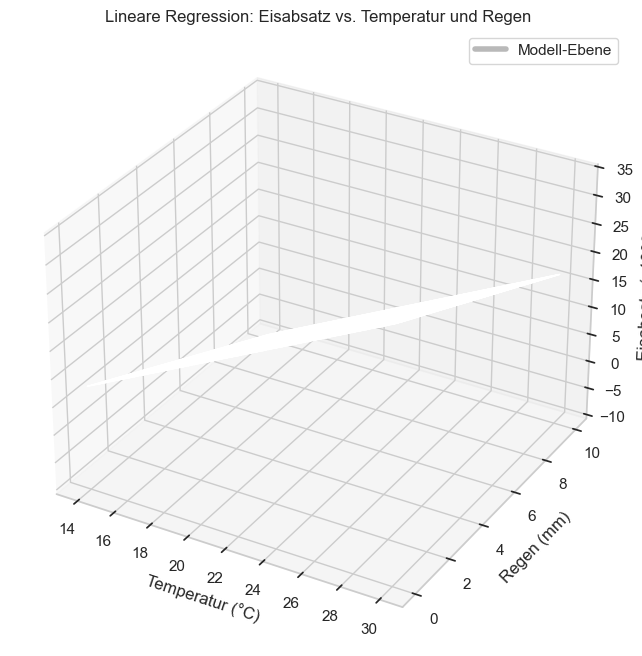

In [80]:
# Erstellen eines Gitters für die Regressionsebene
x_surf, y_surf = np.meshgrid(
    np.linspace(df_transformed['Temperatur'].min(), df_transformed['Temperatur'].max(), 100),
    np.linspace(df_transformed['Regen'].min(), df_transformed['Regen'].max(), 100)
)

# Die Regressionsgleichung lautet: y = a + b*Temperatur + c*Regen
# Wir berechnen den z-Wert (Eisabsatz) für jeden Punkt im Gitter explizit
z_surf = a + b * x_surf + c * y_surf

# 3D-Plot erstellen
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 4. Regressionsebene plotten
ax.plot_surface(x_surf, y_surf, z_surf, alpha=0.2, color='k', label='Modell-Ebene')

# Achsenbeschriftungen und Titel
ax.set_xlabel('Temperatur (°C)')
ax.set_ylabel('Regen (mm)')
ax.set_zlabel('Eisabsatz (x1000 €)')
ax.set_title('Lineare Regression: Eisabsatz vs. Temperatur und Regen')

# Legende anzeigen (ein kleiner Trick ist nötig, um das Oberflächen-Label anzuzeigen)
from matplotlib.lines import Line2D
legend_elements = [
        Line2D([0], [0], color='k', lw=4, label='Modell-Ebene', alpha=0.3)
]
ax.legend(handles=legend_elements)

# Plot anzeigen
plt.show()